# Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines

<br>
<br>

## The environment

In [1]:
import gymnasium as gym

env_id = "BipedalWalker-v3"
env = gym.make(env_id, hardcore=True)

We chose the `BipedalWalker-v3` environment because it's a continuous action space, and it's (when in hardcore mode) a challenging environment to solve.

<br>
<br>

To see the training progress, we use tensorboard to visualize the training progress and took screenshots of the graphs to use them below. 


<br>


```bash
    tensorboard --logdir=logs
```

<br>


<br>



## The algorithms


In the assignment, to use our environment, we needed to choose a few from the following algorithms:

<br>

- ARS (Augmented Random Search)
- A2C (Advantage Actor Critic)
- DDPG (Deep Deterministic Policy Gradient)
- PPO (Proximal Policy Optimization)
- RecurrentPPO (Recurrent Proximal Policy Optimization)
- SAC (Soft Actor Critic)
- TD3 (Twin Delayed DDPG)
- TQC (Twin Q-Value Critic)
- TRPO (Trust Region Policy Optimization)

<br>
<br>




To see the top 3 algorithms, we trained all of them for 1/1.5M iterations and chose the best ones:

To train them, we used `trainnig.py` script.

<br>

## Training all the possible models

To train the models, we called the funtion above with a smaller limit.

Then we got this graph of the training progress:

![graph](media/all_models_original_env.png)

In [2]:
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

def test_performance(model):
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)
    return round(mean_reward, 2)

def draw_performance(performances):
    names, values = zip(*performances)
    cmap = plt.get_cmap('Greens')
    colors = [cmap(i / len(names)) for i in range(len(names))]    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axhline(y=0, color='grey', linestyle='solid', linewidth=1)
    bars = ax.bar(names, values, color=colors, alpha=0.7)
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(value), ha='center')
    ax.set_title('Performance')    
    plt.tight_layout()
    plt.show()
    
def visualize_model(model):
    evaluate_policy(model, gym.make('BipedalWalker-v3', hardcore=True, render_mode="human"), n_eval_episodes=1, warn=False)

Let's test the environment with a random agent from each algorithm:

In [3]:
from stable_baselines3 import A2C, PPO, SAC
from sb3_contrib import ARS, RecurrentPPO, TQC, TRPO

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


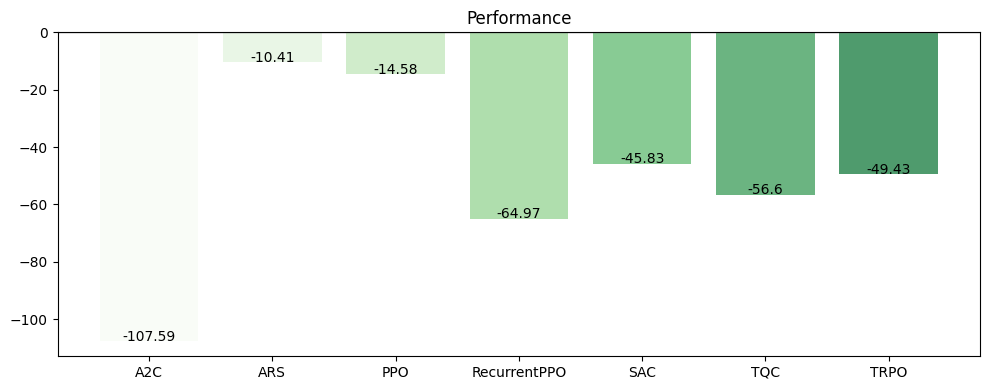

In [4]:
draw_performance([("A2C", test_performance(A2C.load("final_models/A2C_shallow_trained_original_env.zip", env=env))),
                 ("ARS", test_performance(ARS.load("final_models/ARS_shallow_trained_original_env.zip", env=env))),
                 ("PPO", test_performance(PPO.load("final_models/PPO_shallow_trained_original_env.zip", env=env))),
                 ("RecurrentPPO", test_performance(RecurrentPPO.load("final_models/RPPO_shallow_trained_original_env.zip", env=env))),
                 ("SAC", test_performance(SAC.load("final_models/SAC_shallow_trained_original_env.zip", env=env))),
                 ("TQC", test_performance(TQC.load("final_models/TQC_shallow_trained_original_env.zip", env=env))),
                 ("TRPO", test_performance(TRPO.load("final_models/TRPO_shallow_trained_original_env.zip", env=env)))])


## Deeply training the top 5

<br>

We discarded the models that don't have capabilities to train the environment using SubprocVecEnv:
- DDPG
- TD3


Because without it, they are too slow to train.

<br>
Now let's continue the training with the top five algorithms:

- ARS
- PPO
- SAC
- TRPO
- TQC


<br>
<br>

![graph](media/models_in_original_env.png)


<br>

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


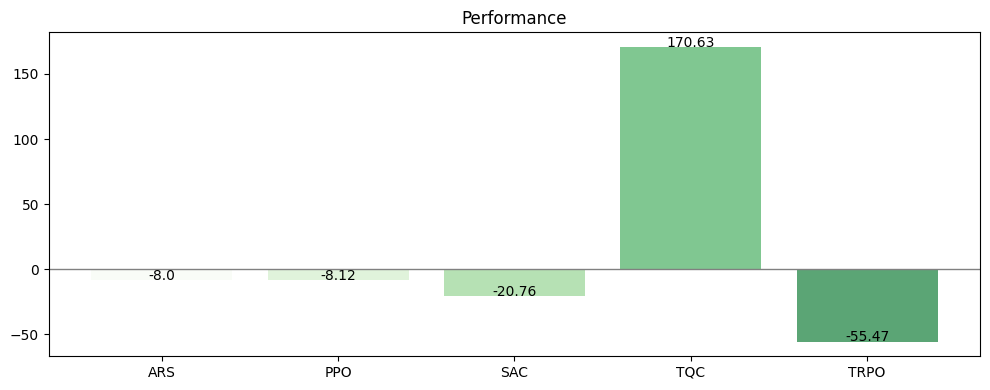

In [5]:
draw_performance([("ARS", test_performance(ARS.load("final_models/ARS_original_env.zip", env=env))),
                  ("PPO", test_performance(PPO.load("final_models/PPO_original_env.zip", env=env))),
                  ("SAC", test_performance(SAC.load("final_models/SAC_original_env.zip", env=env))),
                  ("TQC", test_performance(TQC.load("final_models/TQC_original_env.zip", env=env))),
                  ("TRPO", test_performance(TRPO.load("final_models/TRPO_original_env.zip", env=env)))])

Without any alteration to the environment, the TQC model seems to most of the time very successfully solve the environment.

The other models are clearly struggling with it.


<br>

## Creating a RewardWrapper

<br>

We checked, and the problem seems to be that the walker gets stuck in the same place with its legs open.
<br>

![graph](media/stuck_walker.png)

<br>
<br>

To see if we can improve the results, we will try to reward the agent when it stays balanced upright. Theoretically, this should help the agent to learn how to not get stuck with its legs open.




In [6]:
from gymnasium import RewardWrapper as RW

class BalanceRewardWrapper(RW):
    def __init__(self, environment):
        super().__init__(environment)
        self.env = environment

    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)

        # Add a reward for keeping balance
        balance_reward = abs(obs[2])
        reward += balance_reward

        return obs, reward, done, _, info

To train the models, with the RewardWrapper we need to change the environment creation in the training script:

<br>

```python
env = make_vec_env(env_id, n_envs=NUM_ENVS, wrapper_class=RewardWrapper, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'), env_kwargs=dict(hardcore=True))
```

<br>

Now let's train the models again and check the results.

<br>

![graph](media/models_in_wrapped_env.png)

/opt/homebrew/Caskroom/miniconda/base/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object weights. Consider using `custom_objects` argument to replace this object.
Exception: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


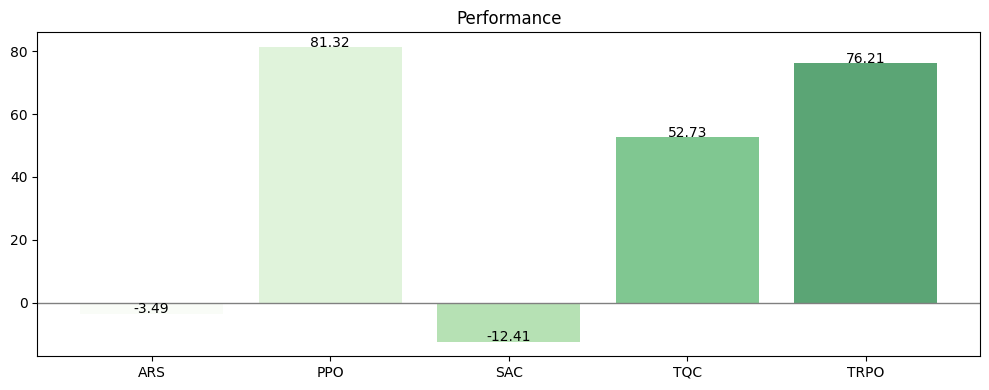

In [7]:
draw_performance([("ARS", test_performance(ARS.load("final_models/ARS_wrapped_env.zip", env=env))),
                  ("PPO", test_performance(PPO.load("final_models/PPO_wrapped_env.zip", env=env))),
                  ("SAC", test_performance(SAC.load("final_models/SAC_wrapped_env.zip", env=env))),
                  ("TQC", test_performance(TQC.load("final_models/TQC_wrapped_env.zip", env=env))),
                  ("TRPO", test_performance(TRPO.load("final_models/TRPO_wrapped_env.zip", env=env)))])

## Conclusion 


As we can see, our reward wrapper generally improved the results of all the models. Except the TQC model that seems to have been affected negatively by the wrapper. 

We can see that the best models we have are the PPO trained with the wrapper and the TQC model without it.


<br>

#### Now let's visualize our progress:


Let's run the models that solve the environment and see how they perform:


```bash
python testing.py TQC_original_env.zip
```

```bash
python testing.py TQC_wrapped_env.zip
```

```bash
python testing.py TRPO_wrapped_env.zip
```

```bash
python testing.py PPO_wrapped_env.zip
```


These scripts will run the models and save the videos to the `media` folder.
The videos are shown in the [ReadME.md](https://github.com/margaridavc/GymEnv/blob/683d67415b07d42ebe5711dd1c278b4e4cf2153e/ReadME.md) file.
